# Directed Sampling 


### initialising logging and notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
!date
BABELDRAW=False

Mi 7. Jun 11:59:48 CEST 2017


### set up graph source

In [2]:
# get data
from eden.io.gspan import gspan_to_eden
from itertools import islice
import graphlearn.utils.draw as draw
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

dataset_fname = '../../toolsdata/bursi.pos.gspan'

### set up a scoring system :D 

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from eden.graph import Vectorizer

class VecComparator():
    def __init__(self, vector):
        self.base = vector 
    def __init__(self,graph, vectorizer):
        self.base = vectorizer.transform([graph])[0]        
    def fit(self,ignore,**ignore2):
        pass
    def predict(self,vector):
        return cosine_similarity(self.base,vector)[0][0]
        
g=get_graphs(dataset_fname)
VC = VecComparator(g.next(),Vectorizer())

### Alternative Scoring System

In [4]:
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from eden.graph import Vectorizer

class VecComparator2(): 

    def __init__(self,vectors, distances, weights):
        self.vectors = vectors
        self.distances = distances
        self.weights = weights
         
    def fit(self,ignore,**ignore2):
        pass
    
    def predict(self,vector):
        def weighted_goal_distance(vec_dist_weigh): 
            dist=euclidean_distances(vec_dist_weigh[0],vector)[0][0]
            return abs(dist-vec_dist_weigh[1])*vec_dist_weigh[2]

        return 1 - sum( map( weighted_goal_distance , zip(self.vectors,self.distances,self.weights)) )
        
        
        
count=5

g=get_graphs(dataset_fname)
vectorizer=Vectorizer()
vecs = vectorizer.transform(g)
dists= euclidean_distances(vecs[0], vecs[1:count])


print(vecs[1:count],dists[0],[1.0/count]*count) 
VC2 = VecComparator2(vecs[1:count+1],dists[0],[1.0/count]*count) 

(<4x65537 sparse matrix of type '<type 'numpy.float64'>'
	with 1405 stored elements in Compressed Sparse Row format>, array([ 1.2053774 ,  1.12902114,  1.19589417,  1.11487118]), [0.2, 0.2, 0.2, 0.2, 0.2])


### set up a sampler (default parameters shown) with the new scoring system

In [5]:
%%time
'''
TRAINING A SAMPLER
'''
from graphlearn.graphlearn import  Sampler
from eden.graph import Vectorizer
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar
from graphlearn.utils.neighbors import getallneighbors
# train a sampler



class mysampler(Sampler):
    def _choose_proposal(self,graph_decomposer):
        #props= [self._propose(graph_decomposer) 
        #                 for x in range( self.proposed_graphs_per_step)]
        def make_decomposers(graphs):
            for g in graphs:
                try:
                    g = self.decomposer.make_new_decomposer(
                    self.graph_transformer.re_transform_single(g))
                    self._score(g)
                except:
                    continue
                yield g
        
        return max(make_decomposers(getallneighbors(graph_decomposer, self.lsgg)), key= lambda x: x._score)
        

class allneighbors_local_iterative_sampler(Sampler):
    
    def _choose_proposal(self,graph_decomposer):
        
        DEBUG=False
        
        ##################
        #  init
        ##################
        def make_decomposers(graphs):
            for g in graphs:
                try:
                    g = self.decomposer.make_new_decomposer(
                    self.graph_transformer.re_transform_single(g))
                    self._score(g)
                except:
                    continue
                yield g    
        if self.step==0:
            self.alis_randomize=0
            
        if DEBUG:
            print "alis_randomize for this round",self.alis_randomize
            
        ######################
        # local search
        ######################
        if self.alis_randomize <= 0:        
            nxt = max(make_decomposers(getallneighbors(graph_decomposer, self.lsgg)), key= lambda x: x._score)
            if DEBUG:
                print "local search branch", nxt._score, graph_decomposer._score
            if nxt._score <= graph_decomposer._score:
                self.alis_randomize = 7
            else:
                return nxt
                
        ######################
        # global search 
        ######################
        if self.alis_randomize > 0:
            if DEBUG:
                print "rand branch.. "
            self.alis_randomize-=1
            graph_decomposer._score = 0 # giving the worst score to the old one to make sure that the new one is accepted, hope that works
            nxt = self._propose(graph_decomposer)
            return nxt
            
        print "RETURN NOTHING>> SOMETHING WENT VERY WRONG"
        
        
        
        
        

sampler=allneighbors_local_iterative_sampler(
                    
                 
                 estimator = VC,
                 grammar=LocalSubstitutableGraphGrammar(radius_list=[0, 1],
                                                        thickness_list=[1,2],
                                                        min_cip_count=2,
                                                        min_interface_count=2), 
                 
                 core_choice_byfrequency=True,
                 core_choice_byscore=False,
                 core_choice_bytrial=False,
                 core_choice_bytrial_multiplier=1.0,
                 size_constrained_core_choice=-1,
                 size_diff_core_filter=-1,   
                 
                 similarity=-1,
                 n_samples=4,
                 proposal_probability=False,
                 batch_size=10,
                 n_jobs=0,

                 orig_cip_max_positives=1,
                 orig_cip_min_positives=0,

                 n_steps=40,
                 quick_skip_orig_cip=False,
                 improving_threshold_fraction=0,
                 improving_linear_start_fraction=0,
                 accept_static_penalty=0.0,
                 accept_min_similarity=0.0,
                 select_cip_max_tries=20,
                 burnin=0,
                 backtrack=0,

                 include_seed=False,
                 keep_duplicates=False,

                 monitor=True,
                proposed_graphs_per_step=5
         
               )


# get training graphs
training_graphs = get_graphs(dataset_fname, size=200)
sampler.fit(training_graphs)

# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

graph grammar stats:
#instances: 200   #interfaces: 155   #cores: 74   #core-interface-pairs: 627
CPU times: user 3.23 s, sys: 144 ms, total: 3.37 s
Wall time: 5.29 s


# Sample and show generated graphs

In [6]:
%%time
from itertools import islice
graphs = get_graphs(dataset_fname, size=100)
id_start=1
id_end=id_start+3
input_graphs = islice(graphs,id_start,id_end)

graphs = sampler.transform(input_graphs)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.9 µs


/home/ikea/GRAPHLEARN/GraphLearn/graphlearn/graphlearn.py:797: RuntimeWarning: divide by zero encountered in double_scalars
  score_ratio = score_graph_new / score_graph_old


Graph id: 1


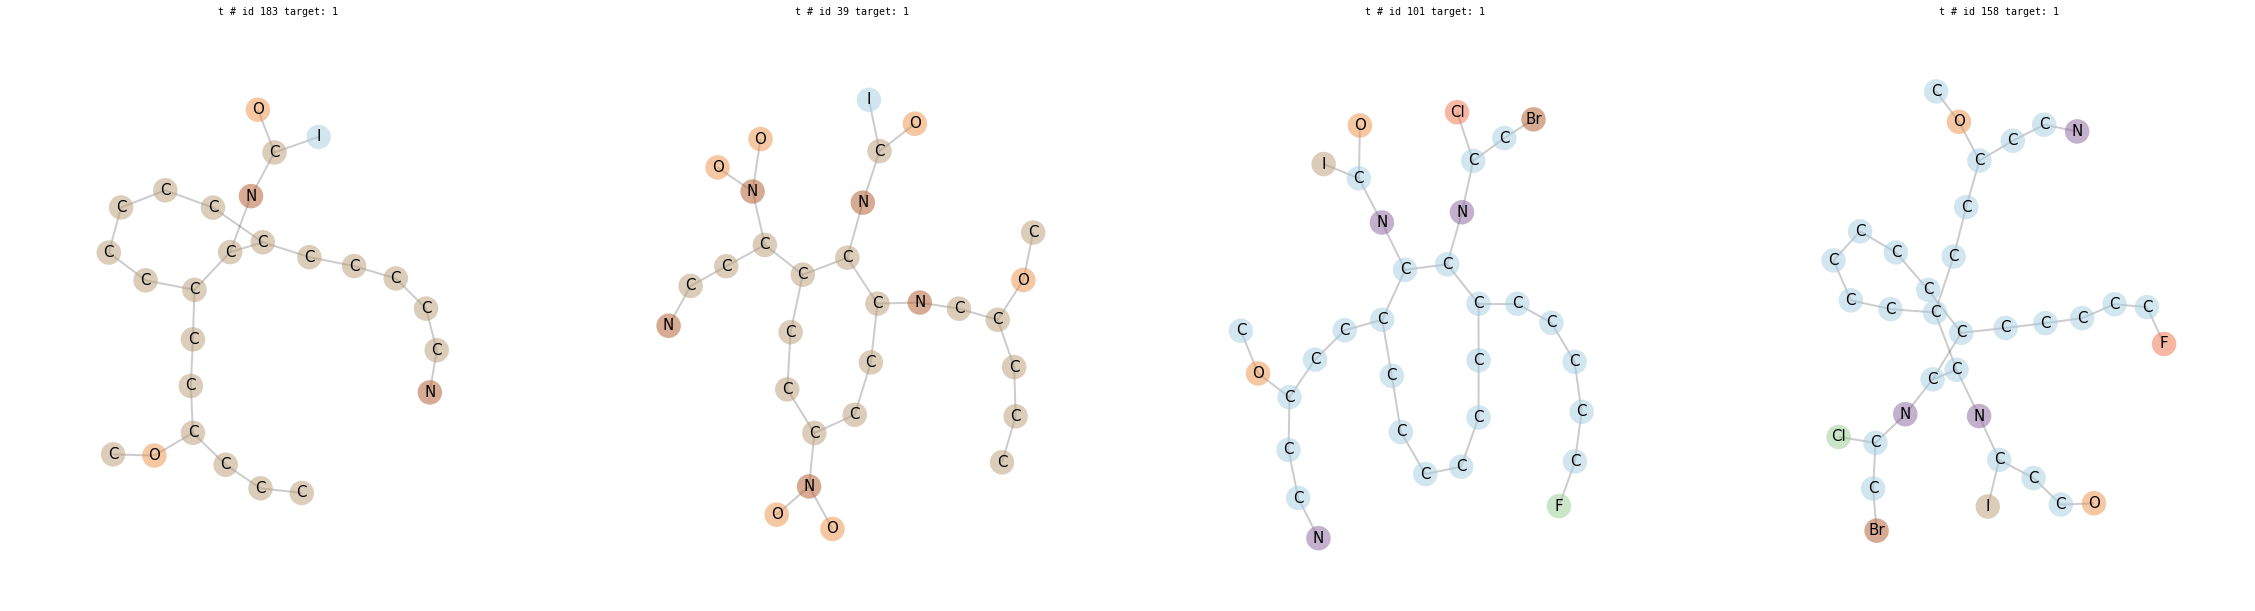

Graph id: 2


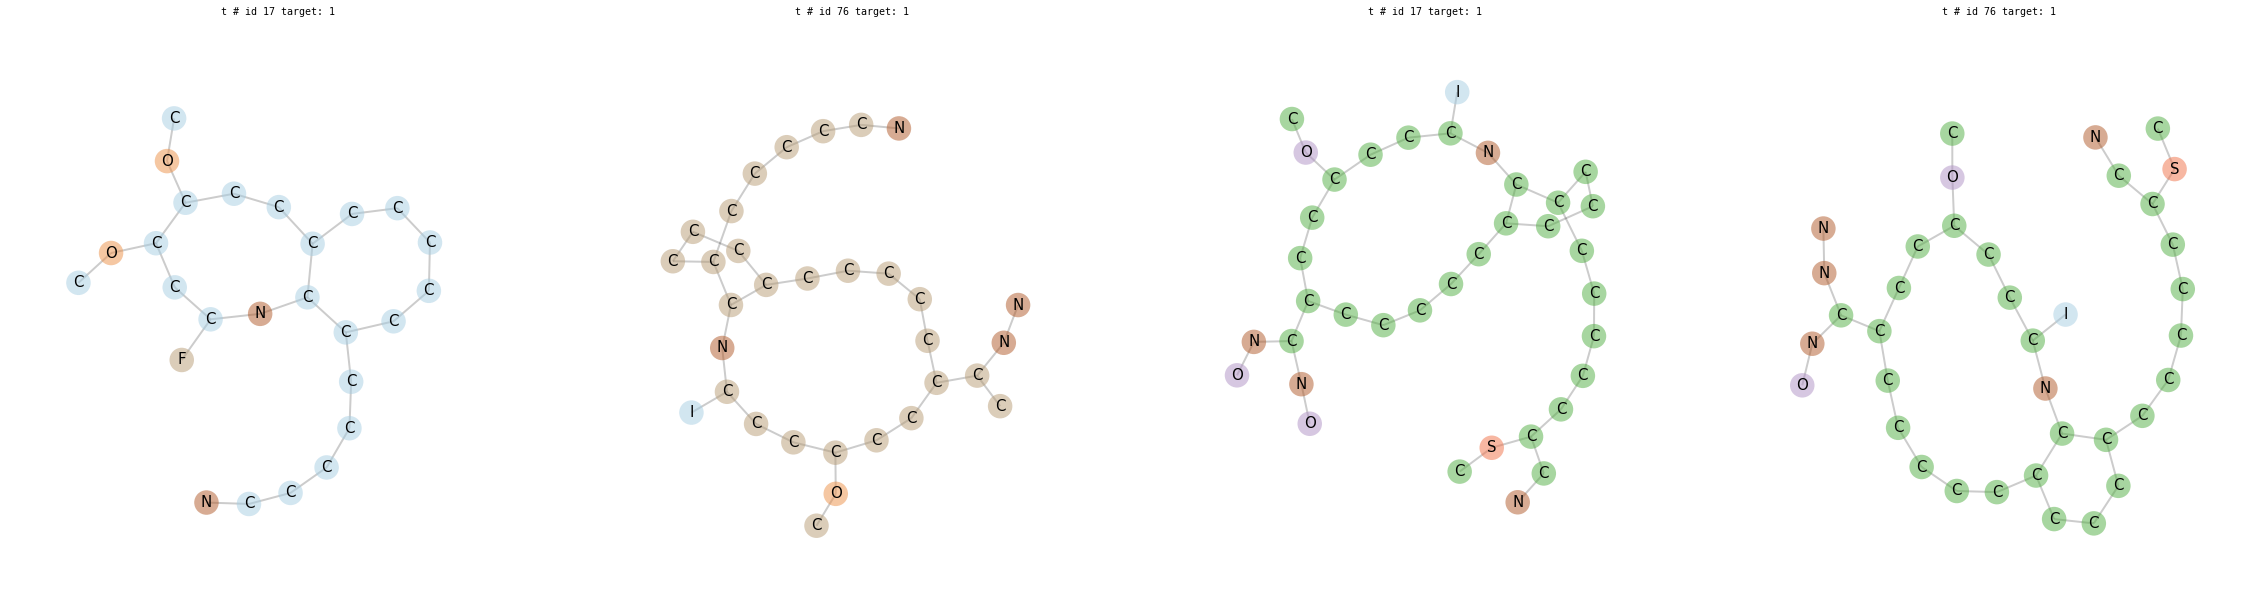

Graph id: 3


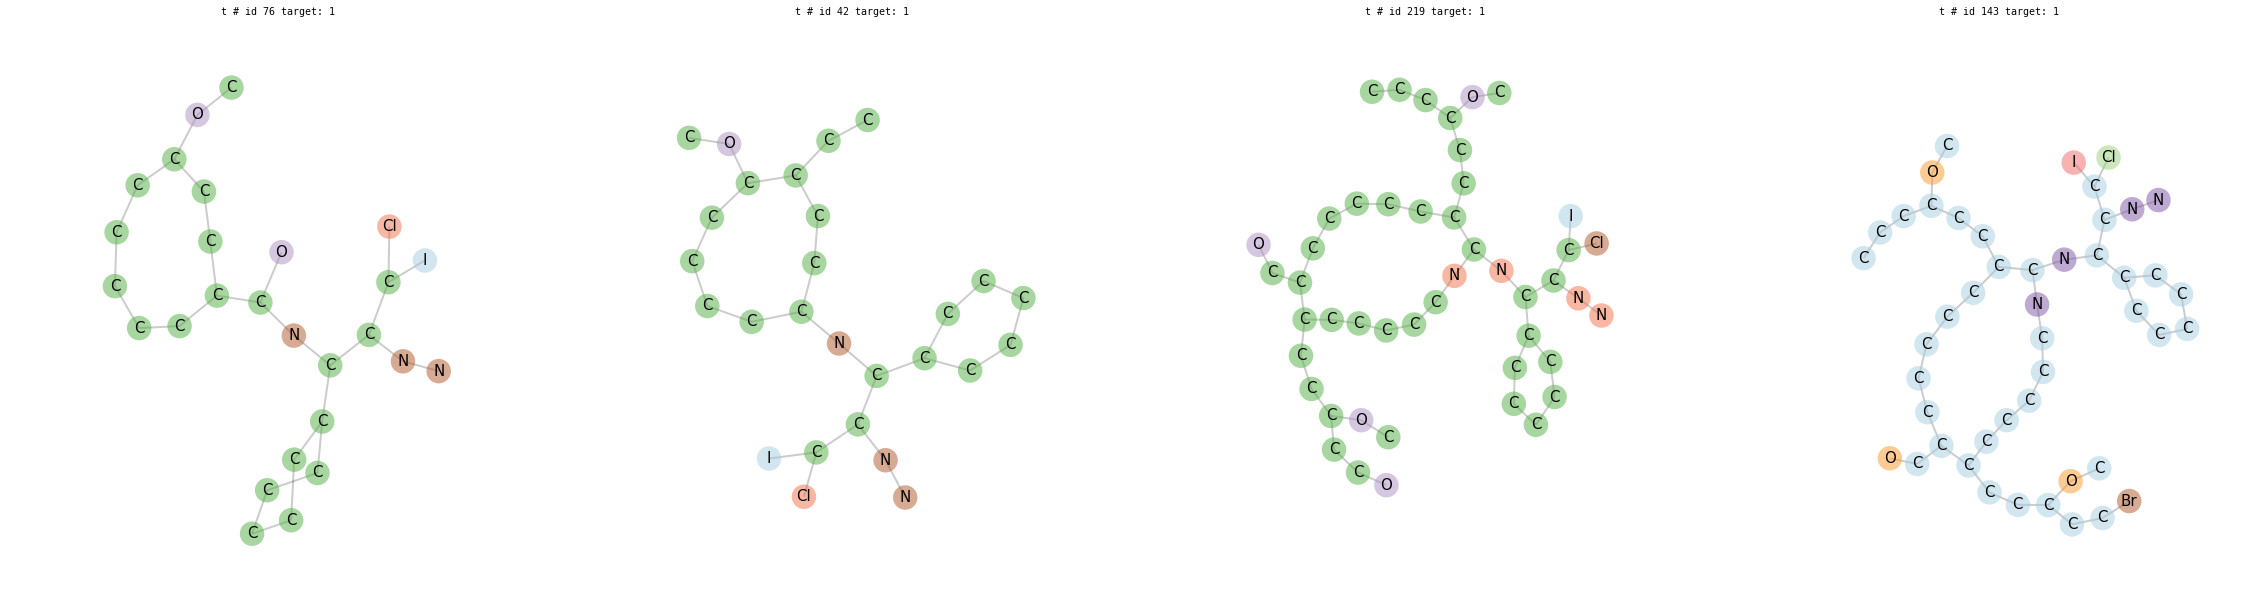

CPU times: user 18min 36s, sys: 4.34 s, total: 18min 40s
Wall time: 18min 43s


In [7]:
%%time
# plot examples of sampling paths

scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    if BABELDRAW:
        from graphlearn.utils import openbabel
        openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)
    else:
        from graphlearn.utils import draw
        draw.graphlearn(graphlist,contract=True,#vertex_label='id',
                   n_graphs_per_line=6, size=10, 
                   colormap='Paired', invert_colormap=False, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2)
    
 

 

In [8]:
# just looking at a monitor to check if everything is ok :) 
sampler.monitors[1].sampling_info

sampler.lsgg.frequency
sampler.size_diff_core_filter

-1

# Show sample score history

1


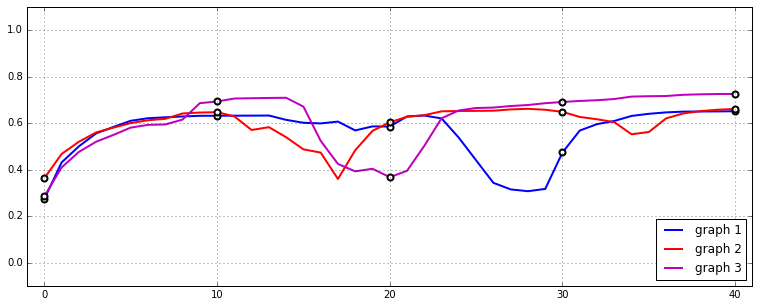

CPU times: user 228 ms, sys: 208 ms, total: 436 ms
Wall time: 205 ms


In [9]:
%%time
# plot sampling path score
n_steps=sampler.n_steps
n_samples= sampler.n_samples


from itertools import islice
import numpy as np
import pylab as plt
markevery=  n_steps/(n_samples) if n_samples else 10
step=1
num_graphs_per_plot=3

import math
num_plots= int(math.ceil(len(scores)/float(num_graphs_per_plot)))
print num_plots
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()
    

    

---